In [2]:
import os
os.chdir('C:\\Code')

In [3]:
pwd

'C:\\Code'

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
image_size=224
batch_size=128
channels=3
epochs=320

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
 "tea sickness dataset",
    seed=123,  
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 885 files belonging to 8 classes.


In [7]:
class_names=dataset.class_names
class_names

['Anthracnose',
 'algal leaf',
 'bird eye spot',
 'brown blight',
 'gray light',
 'healthy',
 'red leaf spot',
 'white spot']

In [8]:
len(dataset)

7

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(128, 224, 224, 3)
[2 5 3 3 7 4 6 3 7 0 3 4 6 1 7 5 4 7 5 6 4 1 6 0 1 0 2 6 7 2 2 2 0 1 7 4 5
 7 5 7 0 3 6 5 7 4 3 4 7 4 2 6 2 7 7 7 1 1 7 6 2 7 2 0 0 3 4 4 6 1 7 3 6 4
 7 1 7 1 1 4 5 2 6 7 7 7 1 3 7 1 3 5 1 5 4 6 0 2 2 6 4 6 6 7 3 3 7 4 6 3 3
 5 2 1 7 6 5 4 4 5 1 5 2 0 6 7 6 4]


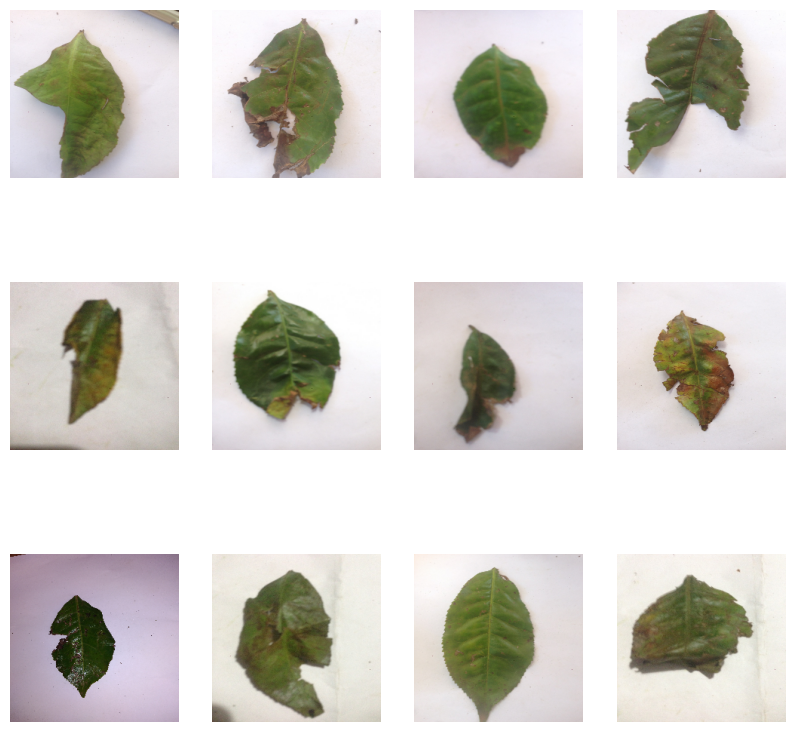

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(3):
    for i in range(12):
        ax=plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis('off')

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds)

5

In [13]:
len(test_ds)

2

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1/255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(image_size, image_size,3)),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (batch_size, image_size, image_size, channels)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(n_classes)
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 224, 224, 3)        0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (128, 224, 224, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (128, 112, 112, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (128, 112, 112, 16)       2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (128, 56, 56, 16)        0         
 2D)                                                  

In [19]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 224, 224, 3)        0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (128, 224, 224, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (128, 112, 112, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (128, 112, 112, 16)       2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (128, 56, 56, 16)        0         
 2D)                                                  

In [23]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=test_ds,
    verbose=1,
    epochs=320,
)

Epoch 1/320
5/5 [==============================] - 12s 2s/step - loss: 1.2322 - accuracy: 0.5156 - val_loss: 1.3922 - val_accuracy: 0.6094
Epoch 2/320
5/5 [==============================] - 12s 2s/step - loss: 1.2610 - accuracy: 0.5078 - val_loss: 1.3833 - val_accuracy: 0.5938
Epoch 3/320
5/5 [==============================] - 12s 3s/step - loss: 1.2332 - accuracy: 0.4906 - val_loss: 1.3980 - val_accuracy: 0.4648
Epoch 4/320
5/5 [==============================] - 12s 3s/step - loss: 1.2251 - accuracy: 0.5031 - val_loss: 1.3676 - val_accuracy: 0.5234
Epoch 5/320
5/5 [==============================] - 12s 3s/step - loss: 1.2611 - accuracy: 0.4844 - val_loss: 1.3328 - val_accuracy: 0.6602
Epoch 6/320
5/5 [==============================] - 12s 2s/step - loss: 1.2905 - accuracy: 0.4547 - val_loss: 1.3917 - val_accuracy: 0.4609
Epoch 7/320
5/5 [==============================] - 12s 2s/step - loss: 1.3014 - accuracy: 0.4641 - val_loss: 1.4396 - val_accuracy: 0.4258
Epoch 8/320
5/5 [==========

5/5 [==============================] - 12s 2s/step - loss: 0.7378 - accuracy: 0.7016 - val_loss: 0.5158 - val_accuracy: 0.7852
Epoch 118/320
5/5 [==============================] - 12s 2s/step - loss: 0.7028 - accuracy: 0.7422 - val_loss: 0.5845 - val_accuracy: 0.7773
Epoch 119/320
5/5 [==============================] - 12s 3s/step - loss: 0.6908 - accuracy: 0.7563 - val_loss: 0.4974 - val_accuracy: 0.8477
Epoch 120/320
5/5 [==============================] - 12s 2s/step - loss: 0.6949 - accuracy: 0.7328 - val_loss: 0.4995 - val_accuracy: 0.8281
Epoch 121/320
5/5 [==============================] - 12s 2s/step - loss: 0.6690 - accuracy: 0.7578 - val_loss: 0.4791 - val_accuracy: 0.8359
Epoch 122/320
5/5 [==============================] - 12s 2s/step - loss: 0.6639 - accuracy: 0.7437 - val_loss: 0.5211 - val_accuracy: 0.8203
Epoch 123/320
5/5 [==============================] - 12s 2s/step - loss: 0.6741 - accuracy: 0.7297 - val_loss: 0.5185 - val_accuracy: 0.8164
Epoch 124/320
5/5 [========

5/5 [==============================] - 22s 5s/step - loss: 0.6336 - accuracy: 0.7578 - val_loss: 0.4896 - val_accuracy: 0.7930
Epoch 234/320
5/5 [==============================] - 22s 5s/step - loss: 0.6151 - accuracy: 0.7734 - val_loss: 0.4523 - val_accuracy: 0.8242
Epoch 235/320
5/5 [==============================] - 22s 4s/step - loss: 0.5238 - accuracy: 0.8031 - val_loss: 0.4268 - val_accuracy: 0.8359
Epoch 236/320
5/5 [==============================] - 22s 5s/step - loss: 0.5482 - accuracy: 0.7937 - val_loss: 0.4895 - val_accuracy: 0.7969
Epoch 237/320
5/5 [==============================] - 16s 3s/step - loss: 0.5305 - accuracy: 0.8094 - val_loss: 0.3594 - val_accuracy: 0.8711
Epoch 238/320
5/5 [==============================] - 12s 2s/step - loss: 0.5536 - accuracy: 0.8000 - val_loss: 0.3717 - val_accuracy: 0.8711
Epoch 239/320
5/5 [==============================] - 14s 3s/step - loss: 0.5525 - accuracy: 0.8078 - val_loss: 0.4009 - val_accuracy: 0.8164
Epoch 240/320
5/5 [========

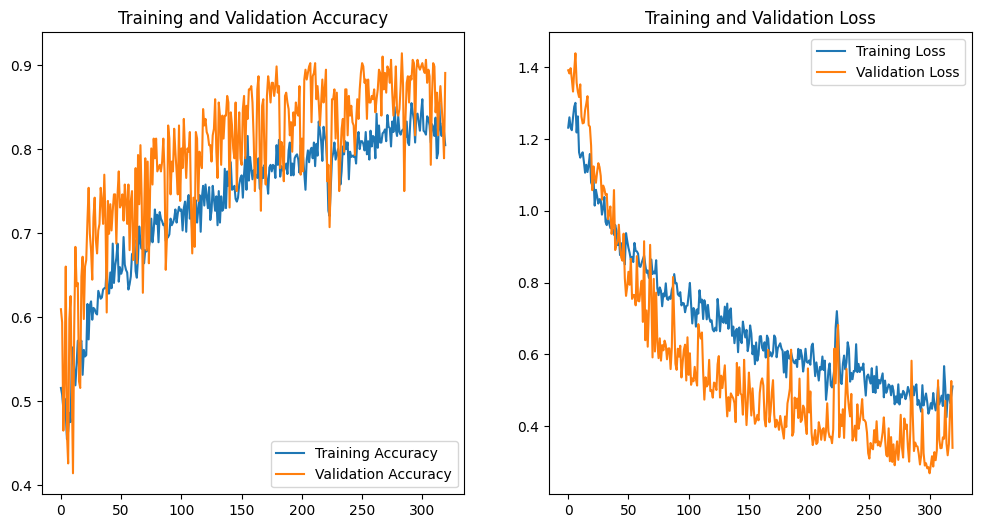

In [24]:
accuracy=history.history['accuracy']
validation_accuracy= history.history['val_accuracy']
loss=history.history['loss']
validation_loss = history.history['val_loss']

epochs_range= range(320)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs_range,accuracy,label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
import numpy as np


In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    
    return predicted_class

1/1 [==============================] - 0s 30ms/step


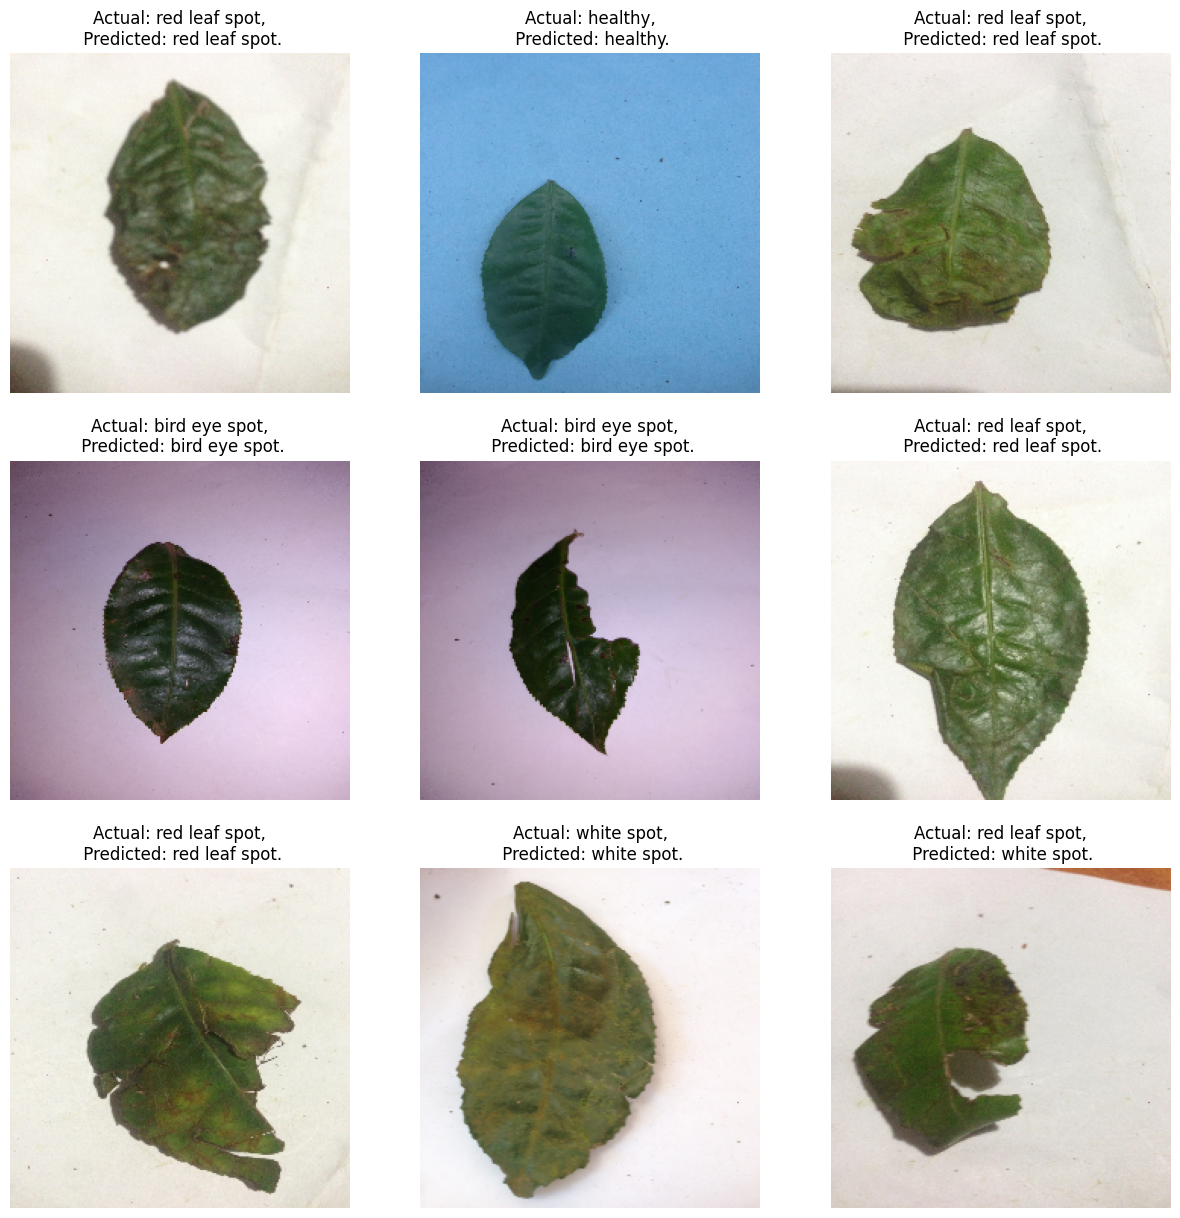

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.")
        
        plt.axis("off")

In [49]:
model_version=2
model.save(f"../models/{model_version}.h5")